In [1]:
import numpy as np
import sys
import os
import fitsio as fi
import pylab as plt
import numpy.fft as npf
tidal_tensor = {}

In [2]:
# set up a toy model box containing just a point mass (or, rather, a very small Gaussian) 
# in the middle
nx = int(128)
n0 = int(nx/2.)
dens = np.zeros((nx,nx,nx))
s = 1

xx,yy,zz=np.meshgrid(np.arange(0,nx,1),np.arange(0,nx,1),np.arange(0,nx,1))
G = 1e8 * np.exp(-((xx-n0)*(xx-n0)/2/s/s+(yy-n0)*(yy-n0)/2/s/s+(zz-n0)*(zz-n0)/2/s/s))

#dens[n0,n0,n0]+=5000
dens += G

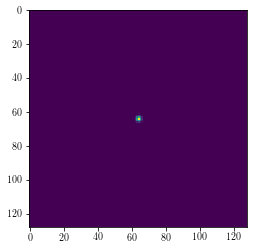

In [3]:
# plot it
plt.imshow(dens[:,:,n0], interpolation='none')
plt.show()

In [4]:
# overdensity field
K = np.mean(dens)
d = dens/K -1 

x = np.arange(-nx/2, nx/2,1)
xx,yy,zz = np.meshgrid(x,x,x)
R = x[n0+1:]

Vpix = (300/nx)**3 # volume of a pixel in Mpc^3

# mean density within a sphere of radius r
rho_bar = np.array([2./3.*np.mean(G[((xx*xx+yy*yy+zz*zz)<r*r)]/Vpix) for r in R])
# mean density at radius r
rho = np.array([np.mean(G[((xx*xx+yy*yy+zz*zz)==r*r)]/Vpix) for r in R])

T00 = (rho_bar-rho)/np.mean(G/Vpix)

# T00 is the theory prediction for the 00 element 
# of the tidal field tensor due to a point mass
# see https://arxiv.org/pdf/0705.3747.pdf eq 20

In [5]:
# set up some arrays for the tidal tensor
k  = npf.fftfreq(nx)[np.mgrid[0:nx,0:nx,0:nx]]
tidal_tensor[nx] = np.zeros((nx,nx,nx,3,3),dtype=np.float32)

# FFT the box
fft_dens = npf.fftn(d) 

# now compute the tidal tensor

for i in range(3):
    for j in range(3):
        print(i,j)
        # k[i], k[j] are 3D matrices
        temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2 + k[2]**2)
        
        # subtract off the trace...
        if (i==j):
            temp -= 1./3 * fft_dens
        
        temp[0,0,0] = 0
        tidal_tensor[nx][:,:,:,i,j] = npf.ifftn(temp).real

0 0


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


Text(0, 0.5, '$S^{ii}(R)$')

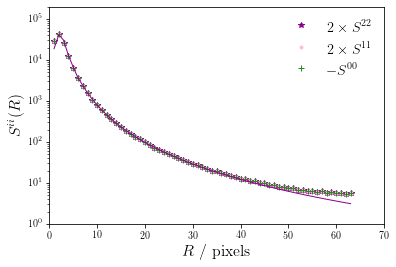

In [6]:

L = 300./float(nx)
x = np.arange(-nx/2, nx/2,1)

plt.plot(x,2*tidal_tensor[nx][n0,n0,:,0,0]*L,'*',color='darkmagenta', label=r'$2 \times S^{22}$')
plt.plot(x,2*tidal_tensor[nx][n0,n0,:,1,1]*L,'.',color='pink', label=r'$2 \times S^{11}$')
plt.plot(x,-tidal_tensor[nx][n0,n0,:,2,2]*L,'+',color='forestgreen', label='$-S^{00}$')

#plt.plot(x,800000/x/x/x)
plt.plot(R,T00*L, color='darkmagenta') # theory line from above

#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e0,2e5)
plt.xlim(0,70)
plt.legend()
plt.xlabel('$R$ / pixels', fontsize=16)
plt.ylabel('$S^{ii}(R)$', fontsize=16)

In [9]:
# repeat all of the above with a different pixel scale (to demonstrate robustness)
nx = int(256)
n0 = int(nx/2.)
dens = np.zeros((nx,nx,nx))
s = 1

xx,yy,zz=np.meshgrid(np.arange(0,nx,1),np.arange(0,nx,1),np.arange(0,nx,1))
G = 1e8 * np.exp(-((xx-n0)*(xx-n0)/2/s/s+(yy-n0)*(yy-n0)/2/s/s+(zz-n0)*(zz-n0)/2/s/s))
dens += G

# overdensity field
K = np.mean(dens)
d = dens/K -1 

# set up some arrays for the tidal tensor
k  = npf.fftfreq(nx)[np.mgrid[0:nx,0:nx,0:nx]]
tidal_tensor[nx] = np.zeros((nx,nx,nx,3,3),dtype=np.float32)

# FFT the box
fft_dens = npf.fftn(d) 

# now compute the tidal tensor

for i in range(3):
    for j in range(3):
        print(i,j)
        # k[i], k[j] are 3D matrices
        temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2 + k[2]**2)
        
        # subtract off the trace...
        if (i==j):
            temp -= 1./3 * fft_dens
        
        temp[0,0,0] = 0
        tidal_tensor[nx][:,:,:,i,j] = npf.ifftn(temp).real
        


0 0


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


Text(0, 0.5, '$S^{00}(R)$')

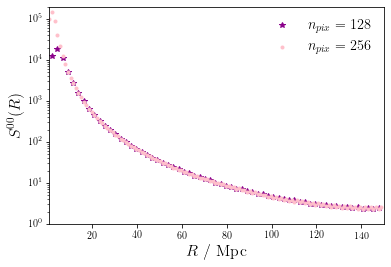

In [18]:

L0 = 300./float(128) # 300 Mpc / no. of pixels
L1 = 300./float(256)

plt.plot(np.arange(-128/2, 128/2,1)*L0, -tidal_tensor[128][int(128/2),int(128/2),:,2,2],'*',color='darkmagenta', label='$n_{pix}=128$')
plt.plot(np.arange(-256/2, 256/2,1)*L1, -tidal_tensor[256][int(256/2),int(256/2),:,2,2],'.',color='pink', label='$n_{pix}=256$' )
plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e0,2e5)
plt.xlim(1e-0,150)
plt.legend()
plt.xlabel('$R$ / Mpc', fontsize=16)
plt.ylabel('$S^{00}(R)$', fontsize=16)